In [10]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Embedding(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.model = nn.Conv2d(3, config.d_model, kernel_size=16, stride=16)

  def forward(self, x):
    B, C, H, W = x.shape
    feature_map = self.model(x) # [B, D, 14, 14]
    embedding = feature_map.view(B, config.d_model, -1).transpose(1,-1)
    return embedding

In [13]:
class Positional_Encoding(nn.Module):
    def __init__(self, image_size=224, patch_size=16, d_model=512):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))

    def forward(self, x):
        B, T, C = x.shape
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)   # [B, T+1, C]
        # Safe slicing in case of mismatch
        x = x + self.pos_embedding[:, :x.size(1), :]
        return x


In [14]:
pe = Positional_Encoding()
pe(torch.rand(4, 196, 512)).shape

torch.Size([4, 197, 512])

In [15]:
class AttentionHead(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.q = nn.Linear(config.d_model, config.d_model)
    self.k = nn.Linear(config.d_model, config.d_model)
    self.v = nn.Linear(config.d_model, config.d_model)
    self.output_proj = nn.Linear(config.d_model, config.d_model)


  def forward(self, x):
    B, T, C = x.shape

    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q = q.view(B, T, config.n_heads, C // config.n_heads ).transpose(1, 2)
    k = k.view(B, T, config.n_heads, C // config.n_heads ).transpose(1, 2)
    v = v.view(B, T, config.n_heads, C // config.n_heads ).transpose(1, 2)

    attn_score = (q @ k.transpose(-1, -2)) * ( 1.0 / math.sqrt(config.d_model))  # [B, n_head, d_model, d_model] there (d_model x d_model) means every tokens has attn_score with another token.
    attn_weights = F.softmax(attn_score, dim = -1)
    attn_output = attn_weights @ v
    attn_output = attn_output.transpose(1,2).contiguous().view(B, T, -1)
    attn_output = self.output_proj(attn_output)
    return attn_output

In [16]:
class FFNN(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.layer1 = nn.Linear(config.d_model, config.hidden_state)
    self.layer2 = nn.Linear(config.hidden_state, config.d_model)

  def forward(self, x):
    x = self.layer1(x)
    x = F.gelu(x)
    x = self.layer2(x)
    return x

In [17]:
class SingleEncoder(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.MultiHeadAttn = AttentionHead(config)
    self.FFNN = FFNN(config)
    self.layer_norm1 = nn.LayerNorm(normalized_shape=config.d_model, eps = config.layer_norm_eps)  # normalized_shape = embedding dim
    self.layer_norm2 = nn.LayerNorm(normalized_shape=config.d_model, eps = config.layer_norm_eps)  # normalized_shape = embedding dim


  def forward(self, x):
    res = x
    x = self.MultiHeadAttn(x)
    x = x + self.layer_norm1(x)

    res = x
    x = self.FFNN(x)
    x = x + self.layer_norm2(x)
    return x

In [18]:
class EncoderStack(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.encoder=SingleEncoder(config)
    self.layers = nn.ModuleList([SingleEncoder(config=config) for _ in range(config.encoder_layer)])

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [19]:
class MLP_Head(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=config.d_model, eps = config.layer_norm_eps)
    self.mlp_head = nn.Linear(config.d_model, config.total_class)

  def forward(self, x):
    prediction_token = x[:, 0]
    x = self.layer_norm(prediction_token)
    x = self.mlp_head(x)
    return x

In [20]:
class TinyViT(nn.Module):

  def __init__(self, config):
    super().__init__()  # Add this line
    self.Embedding = Embedding(config)
    self.PositionE = Positional_Encoding()
    self.EncoderStack = EncoderStack(config)
    self.MLP_Head = MLP_Head(config)

  def forward(self, x):
    x = self.Embedding(x)
    x = self.PositionE(x)
    x = self.EncoderStack(x)
    x = self.MLP_Head(x)
    return x

# **CIFAR-10 DATA**

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transformations (resize to 256x256 for ViT, normalize, augment train set)
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224, padding=4),    # random crop like ImageNet preprocessing
    transforms.RandomHorizontalFlip(),        # flip augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),     # normalize RGB channels
                         (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# CIFAR-10 train & test sets
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

# Dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# Class names
classes = trainset.classes
print("Classes:", classes)

100%|██████████| 170M/170M [00:11<00:00, 15.4MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# **TRAINING LOOP**

In [47]:
class config:
  d_model = 512
  n_heads = 8
  hidden_state = 1024
  total_class = 10
  encoder_layer = 6
  layer_norm_eps = 1e-7

  epochs = 5
  lr = 1e-4
  accumulation_steps = 4   # Simulate larger batch (64*4 = 256)
  device = "cuda" if torch.cuda.is_available() else "cpu"

config = config()

In [48]:
model = TinyViT(config).to(config.device)

In [49]:
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)   # Xavier for linear
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

# Apply after model creation
model = model.apply(init_weights)


In [50]:
all_train_loss = []
all_val_loss = []

In [51]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs)

In [52]:
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# Loss + Optimizer + Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs)
scaler = torch.amp.GradScaler("cuda")  # mixed precision

# Training loop
for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for step, (inputs, targets) in tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, targets = inputs.to(config.device), targets.to(config.device)

        # Mixed precision forward
        with torch.amp.autocast("cuda"):
            outputs = model(inputs)
            loss = criterion(outputs, targets) / config.accumulation_steps

        # Backward
        scaler.scale(loss).backward()

        # Gradient accumulation step
        if (step + 1) % config.accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * config.accumulation_steps
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = 100. * correct / total
    train_loss = running_loss / len(trainloader)
    all_train_loss.append(train_loss)

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            with torch.amp.autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_acc = 100. * val_correct / val_total
    val_loss /= len(testloader)
    all_val_loss.append(val_loss)

    # Step scheduler at the end of each epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{config.epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% "
          f"| LR: {scheduler.get_last_lr()[0]:.6f}")

100%|██████████| 782/782 [02:28<00:00,  5.25it/s]


Epoch [1/5] Train Loss: 2.0845 | Train Acc: 21.90% | Val Loss: 1.9413 | Val Acc: 26.77% | LR: 0.000090


100%|██████████| 782/782 [02:28<00:00,  5.26it/s]


Epoch [2/5] Train Loss: 1.9190 | Train Acc: 28.20% | Val Loss: 1.8280 | Val Acc: 31.40% | LR: 0.000065


100%|██████████| 782/782 [02:28<00:00,  5.26it/s]


Epoch [3/5] Train Loss: 1.7924 | Train Acc: 32.98% | Val Loss: 1.7722 | Val Acc: 34.85% | LR: 0.000035


100%|██████████| 782/782 [02:27<00:00,  5.29it/s]


Epoch [4/5] Train Loss: 1.7020 | Train Acc: 37.06% | Val Loss: 1.7112 | Val Acc: 36.95% | LR: 0.000010


100%|██████████| 782/782 [02:28<00:00,  5.28it/s]


Epoch [5/5] Train Loss: 1.6372 | Train Acc: 39.64% | Val Loss: 1.6280 | Val Acc: 40.45% | LR: 0.000000


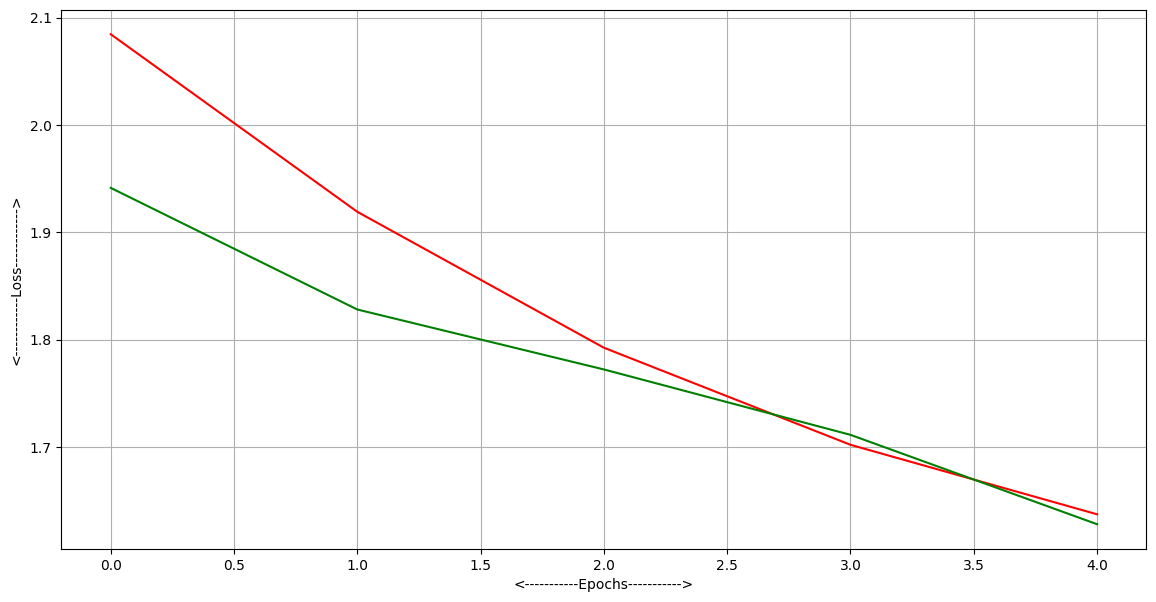

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))  # width=14, height=7 (larger figure = zoomed out)
plt.plot(all_train_loss, c = 'r')
plt.plot(all_val_loss, c='g')
plt.xlabel('<-----------Epochs----------->')
plt.ylabel('<------------Loss------------>')
plt.grid(True)
plt.show()

In [53]:
torch.save(model.state_dict(), "Tint-ViT-CIFAR-10.pth")

In [131]:
# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)


# Trainable parameters only
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

Total parameters: 15220746
Trainable parameters: 15220746


# **INFERENCE**

In [55]:
model.load_state_dict(torch.load('/content/Tint-ViT-CIFAR-10.pth'))

<All keys matched successfully>

In [56]:
model.eval()

TinyViT(
  (Embedding): Embedding(
    (model): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (PositionE): Positional_Encoding()
  (EncoderStack): EncoderStack(
    (encoder): SingleEncoder(
      (MultiHeadAttn): AttentionHead(
        (q): Linear(in_features=512, out_features=512, bias=True)
        (k): Linear(in_features=512, out_features=512, bias=True)
        (v): Linear(in_features=512, out_features=512, bias=True)
        (output_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (FFNN): FFNN(
        (layer1): Linear(in_features=512, out_features=1024, bias=True)
        (layer2): Linear(in_features=1024, out_features=512, bias=True)
      )
      (layer_norm1): LayerNorm((512,), eps=1e-07, elementwise_affine=True)
      (layer_norm2): LayerNorm((512,), eps=1e-07, elementwise_affine=True)
    )
    (layers): ModuleList(
      (0-5): 6 x SingleEncoder(
        (MultiHeadAttn): AttentionHead(
          (q): Linear(in_features=512, out_featur

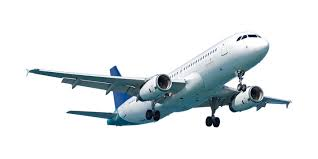

In [109]:
from PIL import Image
from torchvision import transforms


img = Image.open("aeroplane.jpg").convert("RGB")
img

In [110]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

tensor = transform(img)

In [111]:
y_pred = model(tensor.unsqueeze(0).to("cuda"))

In [114]:
output_class = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [118]:
probs = F.softmax(y_pred, dim = -1)[0]*100
probs

tensor([58.3771,  1.3808,  7.3387,  9.8852,  4.2319,  4.9456,  1.2424,  2.1685,
         9.2413,  1.1886], device='cuda:0', grad_fn=<MulBackward0>)

# **WITH LESS EPOCHS AND CONFIG, THE RESULTS ARE NOT THAT BAD**

In [128]:
for i, cls in enumerate(output_class):
  print(f'{cls} = = {probs[i]:.2f}%')

airplane = = 58.38%
automobile = = 1.38%
bird = = 7.34%
cat = = 9.89%
deer = = 4.23%
dog = = 4.95%
frog = = 1.24%
horse = = 2.17%
ship = = 9.24%
truck = = 1.19%
